In [57]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [58]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [59]:

tnia_images_path = Path(r"D:\images\tnia-python-images")

parent_path=Path(tnia_images_path / r'imagesc/2024_01_10_insect_egg_count')
test_name='I1_F1_O20_SWI_R1_13-09-23.tif'
n_rays = 32

train_path = parent_path / 'labels'

with open(train_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = train_path / 'ground truth0'
label_patch_path = train_path / 'input0'

model_path = parent_path / 'model'

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YXC


## Use a helper to collect the training data

The helper will also normalize the inputs.

In [60]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False
if axes == 'YX':
    add_trivial_channel = True

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

type X  <class 'list'>
type Y  <class 'list'>


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256)
0.0 1.8358209


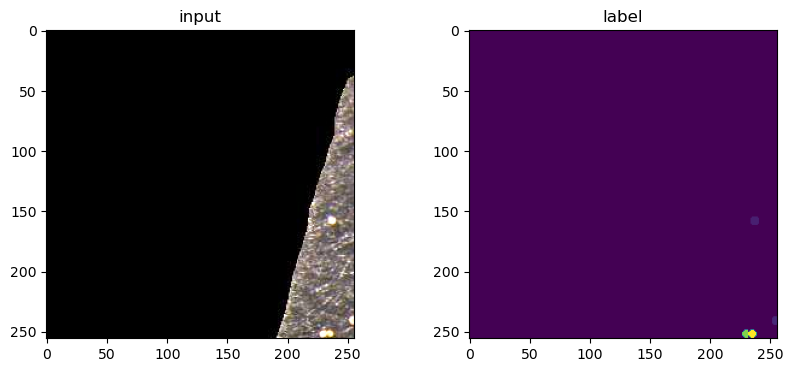

In [61]:

print(X[0].shape, Y[0].shape)
print(X[0].min(), X[0].max())
fig=imshow_multi2d([X[0], Y[0]], ['input', 'label'], 1,2)

## Divide in to training and validation sets

Use a helper to divide into training and validation.  Note the conversion to numpy arrays (needed for stardist training) is also baked into the divide_training_data function

In [62]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=0)

print('type X_train ', type(X_train))

type X_train  <class 'numpy.ndarray'>


## Create stardist model

In [64]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

if axes == 'YXC':
    n_channel_in =3
else:
    n_channel_in = 1


config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=4)

model = StarDist2D(config=config, name="model1", basedir=model_path)

base_model.py (149): output path for model already exists, files may be overwritten: D:\images\tnia-python-images\imagesc\2024_01_10_insect_egg_count\model\model1


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.391854, nms_thresh=0.3.


## Train the model

In [68]:
print(X_train.shape, Y_train.shape)
X_val = X_train[0:2,:,:,:]
Y_val = Y_train[0:2,:,:]

(12, 256, 256, 3) (12, 256, 256)


In [19]:
print(config)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=4, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

In [74]:
help(model.train)

Help on method train in module stardist.models.model2d:

train(X, Y, validation_data, classes='auto', augmenter=None, seed=None, epochs=None, steps_per_epoch=None, workers=1) method of stardist.models.model2d.StarDist2D instance
    Train the neural network with the given data.
    
    Parameters
    ----------
    X : tuple, list, `numpy.ndarray`, `keras.utils.Sequence`
        Input images
    Y : tuple, list, `numpy.ndarray`, `keras.utils.Sequence`
        Label masks
    classes (optional): 'auto' or iterable of same length as X
         label id -> class id mapping for each label mask of Y if multiclass prediction is activated (n_classes > 0)
         list of dicts with label id -> class id (1,...,n_classes)
         'auto' -> all objects will be assigned to the first non-background class,
                   or will be ignored if config.n_classes is None
    validation_data : tuple(:class:`numpy.ndarray`, :class:`numpy.ndarray`) or triple (if multiclass)
        Tuple (triple if 

In [90]:
model.train(X_train, Y_train,epochs=50, validation_data=(X_val, Y_val), steps_per_epoch=50, augmenter=augmenter) 

Epoch 1/50
50/50 [==============================] - 7s 137ms/step - loss: 0.1332 - prob_loss: 0.0148 - dist_loss: 0.5922 - prob_kld: 0.0033 - dist_relevant_mae: 0.5921 - dist_relevant_mse: 0.7380 - dist_dist_iou_metric: 0.7223 - val_loss: 0.1498 - val_prob_loss: 0.0355 - val_dist_loss: 0.5714 - val_prob_kld: 0.0074 - val_dist_relevant_mae: 0.5713 - val_dist_relevant_mse: 0.6591 - val_dist_dist_iou_metric: 0.7303 - lr: 3.0000e-04
Epoch 2/50
50/50 [==============================] - 7s 143ms/step - loss: 0.1332 - prob_loss: 0.0150 - dist_loss: 0.5914 - prob_kld: 0.0035 - dist_relevant_mae: 0.5912 - dist_relevant_mse: 0.7360 - dist_dist_iou_metric: 0.7227 - val_loss: 0.1460 - val_prob_loss: 0.0353 - val_dist_loss: 0.5534 - val_prob_kld: 0.0072 - val_dist_relevant_mae: 0.5532 - val_dist_relevant_mse: 0.6481 - val_dist_dist_iou_metric: 0.7457 - lr: 3.0000e-04
Epoch 3/50
50/50 [==============================] - 7s 135ms/step - loss: 0.1300 - prob_loss: 0.0150 - dist_loss: 0.5749 - prob_kld: 0

In [91]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:00<00:00, 33.35it/s, 0.560 -> 0.959]


Using optimized values: prob_thresh=0.557282, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5572823392592969, 'nms': 0.3}

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

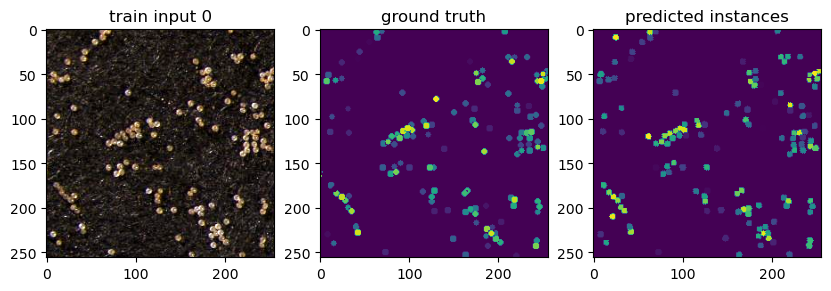

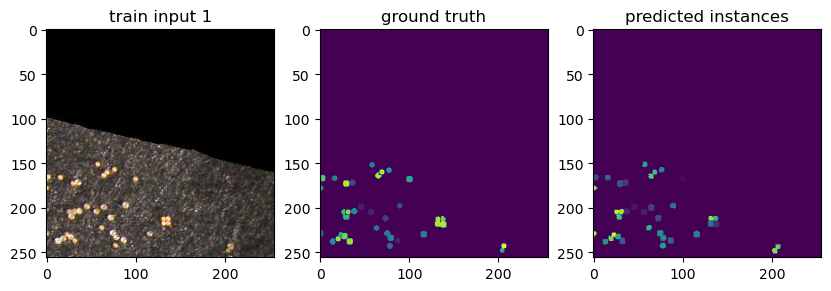

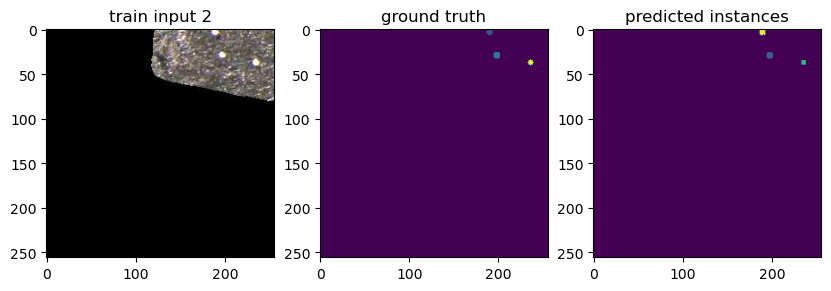

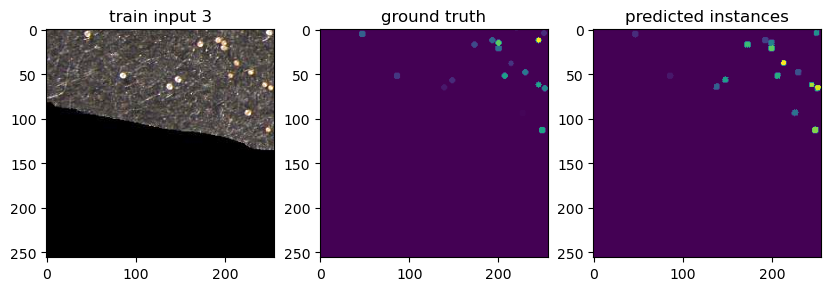

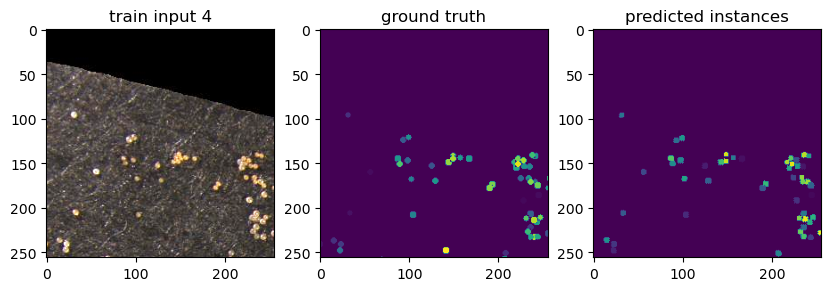

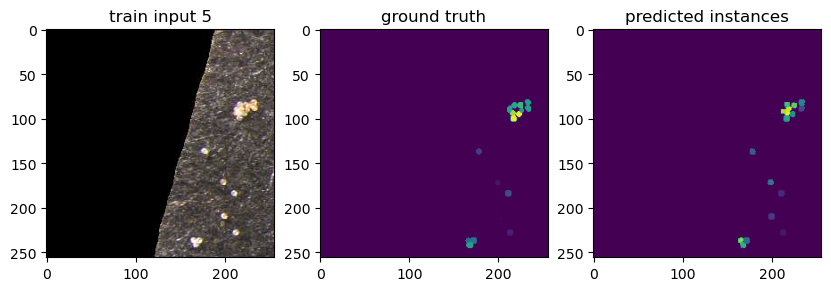

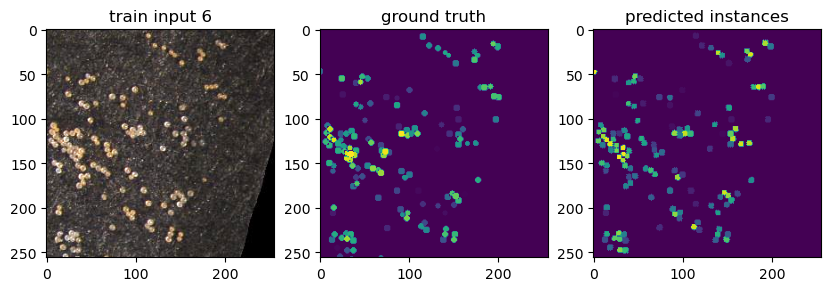

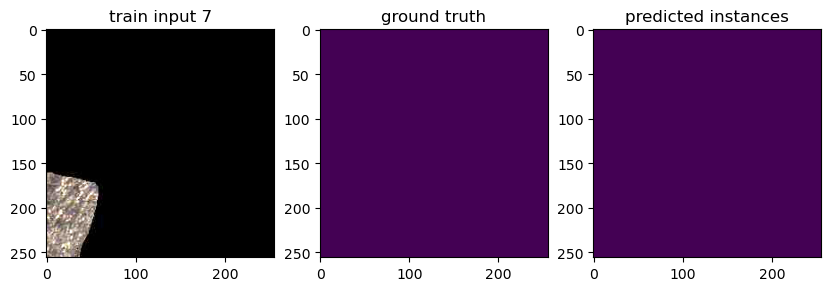

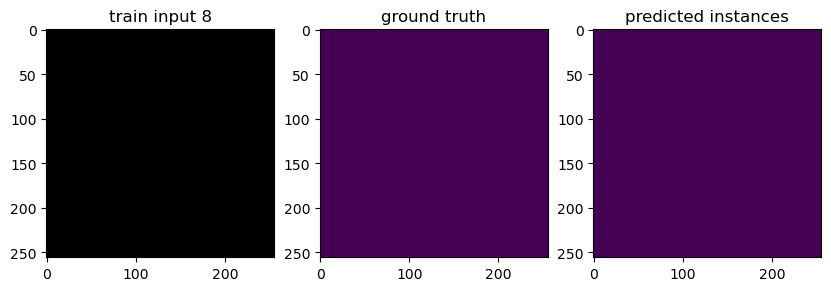

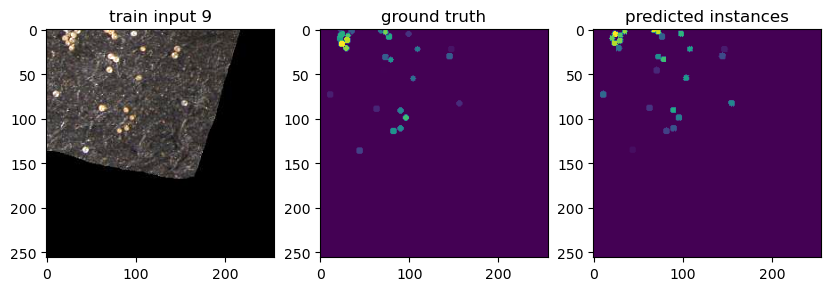

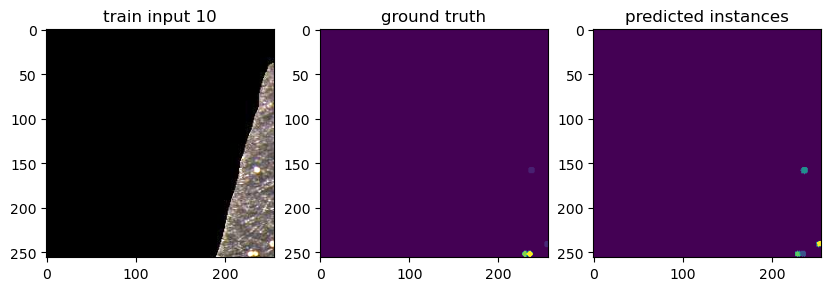

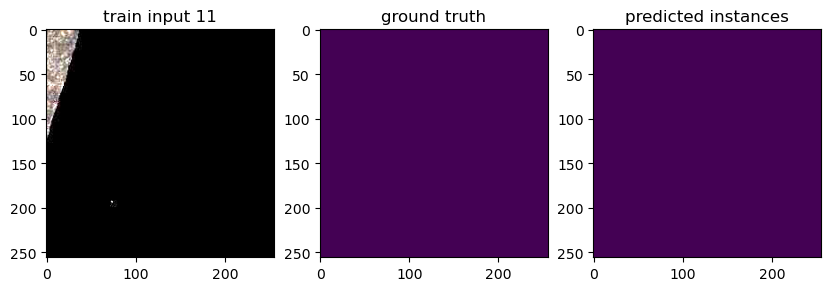

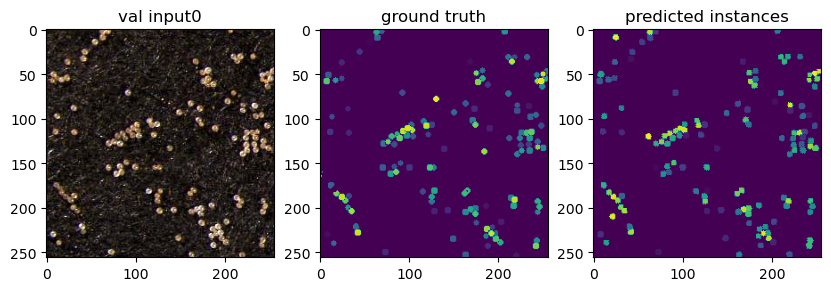

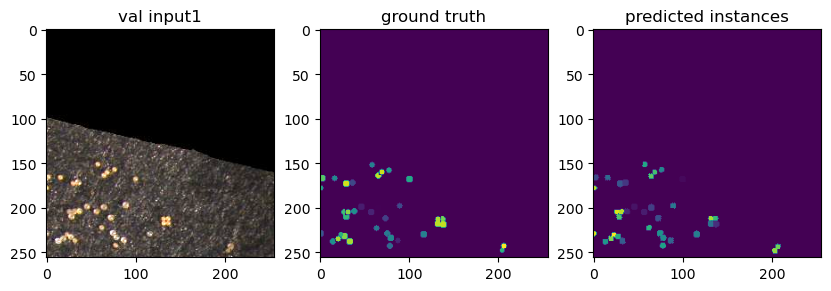

In [71]:

for n in range(len(X_train)):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.1, nms_thresh=0.1)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['train input '+str(n),'ground truth','predicted instances'],1,3)


for n in range(len(X_val)):
    labels, details = model.predict_instances(X_val[n], prob_thresh=0.1, nms_thresh=0.1)
    fig = imshow_multi2d([X_val[n],Y_val[n],labels],['val input'+str(n),'ground truth','predicted instances'],1,3)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


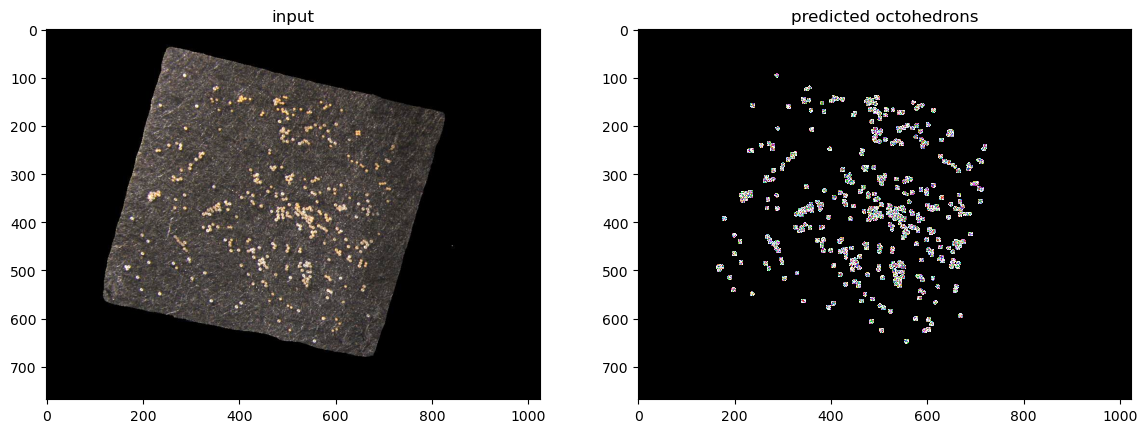

In [92]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize
import numpy as np

testim = imread(parent_path  / test_name) 
if (sub_sample != 1):
    testim = testim[::sub_sample,::sub_sample]  
#testim = normalize(testim,20,99.8, axis=(0,1))
testim = normalize(testim,3,99.8)
labels, details = model.predict_instances(testim, prob_thresh=0.1, nms_thresh=0.3)

if n_rays == 4:
    labels2 = np.zeros_like(labels)#ray4_to_ellipsoid2d_labels(details['coord'], testim.shape)
    fig = imshow_multi2d([testim,labels,labels2],['input','predicted octohedrons', 'rendered as ellipses'],1,3, width=14, height=8,colormaps=['gray', random_label_cmap(), random_label_cmap()])
else:
    fig = imshow_multi2d([testim,labels],['input','predicted octohedrons'],1,2, width=14, height=8,colormaps=['gray', random_label_cmap()])

In [93]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels2')

<Labels layer 'labels2' at 0x23ed6e2e5e0>